<a href="https://colab.research.google.com/github/pichuu12/All-projects-and-Internship-tasks/blob/main/food_classification_project/Food_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOOD CLASSIFICATION - 101 categories


*   The goal of the project is to beat the DeepFood paper published in 2016 which categorizes 101 food categories with an accuracy of 77.4%

Dataset - [Drive Link](https://drive.google.com/file/d/1mdoM82J4u5kdrHN0rbE7eWpjDQhdXKNl/view?usp=sharing)


## Training and Testing Model with only 10% of original dataset

In [1]:
!nvidia-smi

Tue Mar 14 11:04:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing helper functions

In [2]:
!wget https://raw.githubusercontent.com/pichuu12/All-projects-and-Internship-tasks/main/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2023-03-14 11:04:50--  https://raw.githubusercontent.com/pichuu12/All-projects-and-Internship-tasks/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5234 (5.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   5.11K  --.-KB/s    in 0s      

2023-03-14 11:04:50 (72.0 MB/s) - ‘helper_functions.py’ saved [5234/5234]



### Getting dataset from google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip /content/gdrive/MyDrive/food_dataset/101_food_classes_10_percent.zip

Streaming output truncated to the last 5000 lines.
  inflating: 101_food_classes_10_percent/train/beet_salad/2450020.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/550087.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3132380.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/44885.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1967147.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1422905.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1380319.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1336726.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/2808614.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/66574.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3537144.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3165387.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3391241.jpg  
  inflating: 101_f

In [8]:
import tensorflow as tf

In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_fries'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 

### Setting up datasets

In [9]:
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [10]:
#checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor="val_accuracy", 
                                                         save_best_only=True) 

### Data Augmentation

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2), 
], name="data_augmentation")

### Base model setup

In [12]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer") 
x = data_augmentation(inputs)
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) 
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [14]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), 
                                           callbacks=[checkpoint_callback]) 

Epoch 1/5


237/237 [==============================] - 132s 480ms/step - loss: 3.3849 - accuracy: 0.2676 - val_loss: 2.6312 - val_accuracy: 0.4182
Epoch 2/5
237/237 [==============================] - 99s 415ms/step - loss: 2.2036 - accuracy: 0.4970 - val_loss: 2.1315 - val_accuracy: 0.4860
Epoch 3/5
237/237 [==============================] - 91s 379ms/step - loss: 1.8252 - accuracy: 0.5661 - val_loss: 1.9801 - val_accuracy: 0.5077
Epoch 4/5
237/237 [==============================] - 86s 359ms/step - loss: 1.6130 - accuracy: 0.6038 - val_loss: 1.8718 - val_accuracy: 0.5230
Epoch 5/5
237/237 [==============================] - 84s 353ms/step - loss: 1.4481 - accuracy: 0.6469 - val_loss: 1.8375 - val_accuracy: 0.5238


In [15]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 64s 81ms/step - loss: 1.5931 - accuracy: 0.5804


[1.593071460723877, 0.5803960561752319]

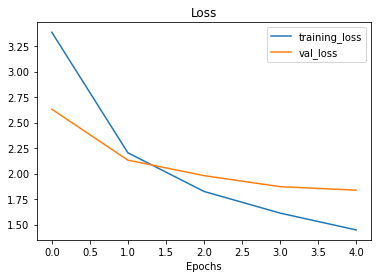

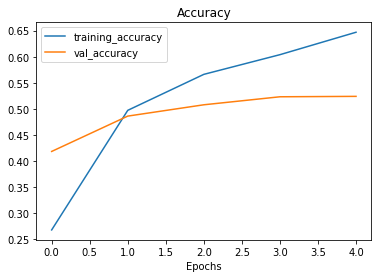

In [16]:
plot_loss_curves(history_all_classes_10_percent)

### Fine Tuning

In [17]:
# Unfreeze layers
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
#recompile
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=['accuracy'])

In [19]:
#check for trainable layers
for layer in model.layers:
  print(layer.name, layer.trainable)

print('\n')
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation 

In [20]:
#training again for 5 more epochs
fine_tune_epochs = 10 

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), 
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) 

Epoch 5/10


237/237 [==============================] - 95s 353ms/step - loss: 1.2225 - accuracy: 0.6797 - val_loss: 1.7467 - val_accuracy: 0.5426
Epoch 6/10
237/237 [==============================] - 76s 319ms/step - loss: 1.0936 - accuracy: 0.7075 - val_loss: 1.7449 - val_accuracy: 0.5471
Epoch 7/10
237/237 [==============================] - 76s 321ms/step - loss: 1.0279 - accuracy: 0.7216 - val_loss: 1.7434 - val_accuracy: 0.5463
Epoch 8/10
237/237 [==============================] - 77s 321ms/step - loss: 0.9505 - accuracy: 0.7481 - val_loss: 1.7313 - val_accuracy: 0.5516
Epoch 9/10
237/237 [==============================] - 74s 306ms/step - loss: 0.8922 - accuracy: 0.7634 - val_loss: 1.7457 - val_accuracy: 0.5471
Epoch 10/10
237/237 [==============================] - 73s 308ms/step - loss: 0.8421 - accuracy: 0.7774 - val_loss: 1.7962 - val_accuracy: 0.5381


In [21]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 60s 75ms/step - loss: 1.5103 - accuracy: 0.6018


[1.510330319404602, 0.601821780204773]

* we got a slight boost from the previous model

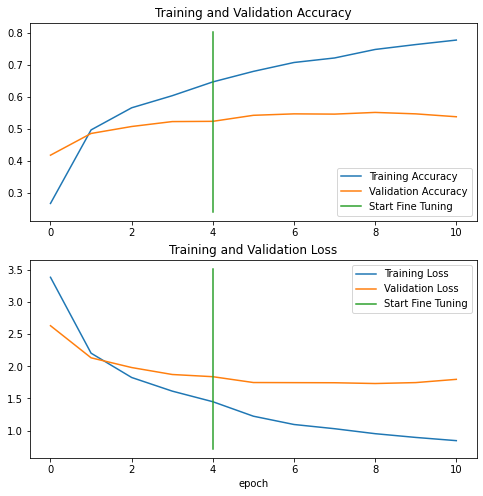

In [22]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

### Evaluating Model performance

In [23]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 64s 79ms/step


In [24]:
pred_probs.shape

(25250, 101)

In [25]:
pred_probs[:10]

array([[1.9768664e-01, 4.5787773e-04, 1.9721070e-01, ..., 5.4167112e-06,
        1.8947669e-03, 7.8120353e-03],
       [8.9622062e-01, 5.1982287e-08, 1.5075554e-03, ..., 3.7533734e-03,
        6.7795395e-07, 4.3049113e-06],
       [2.8796667e-01, 3.0242015e-02, 4.2773698e-02, ..., 2.1080289e-04,
        7.2247139e-04, 3.2555286e-03],
       ...,
       [1.5433082e-01, 8.6525579e-06, 2.5402608e-03, ..., 9.5264733e-02,
        6.8762235e-04, 6.1445266e-05],
       [1.2592413e-01, 3.5131071e-04, 3.5272264e-01, ..., 1.8748705e-04,
        4.9693717e-05, 1.6751169e-04],
       [5.4865015e-01, 9.1209006e-07, 3.2970612e-03, ..., 6.1976011e-03,
        1.1474164e-06, 1.0339156e-03]], dtype=float32)

In [26]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  9,  0])

In [27]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6018217821782178

In [29]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

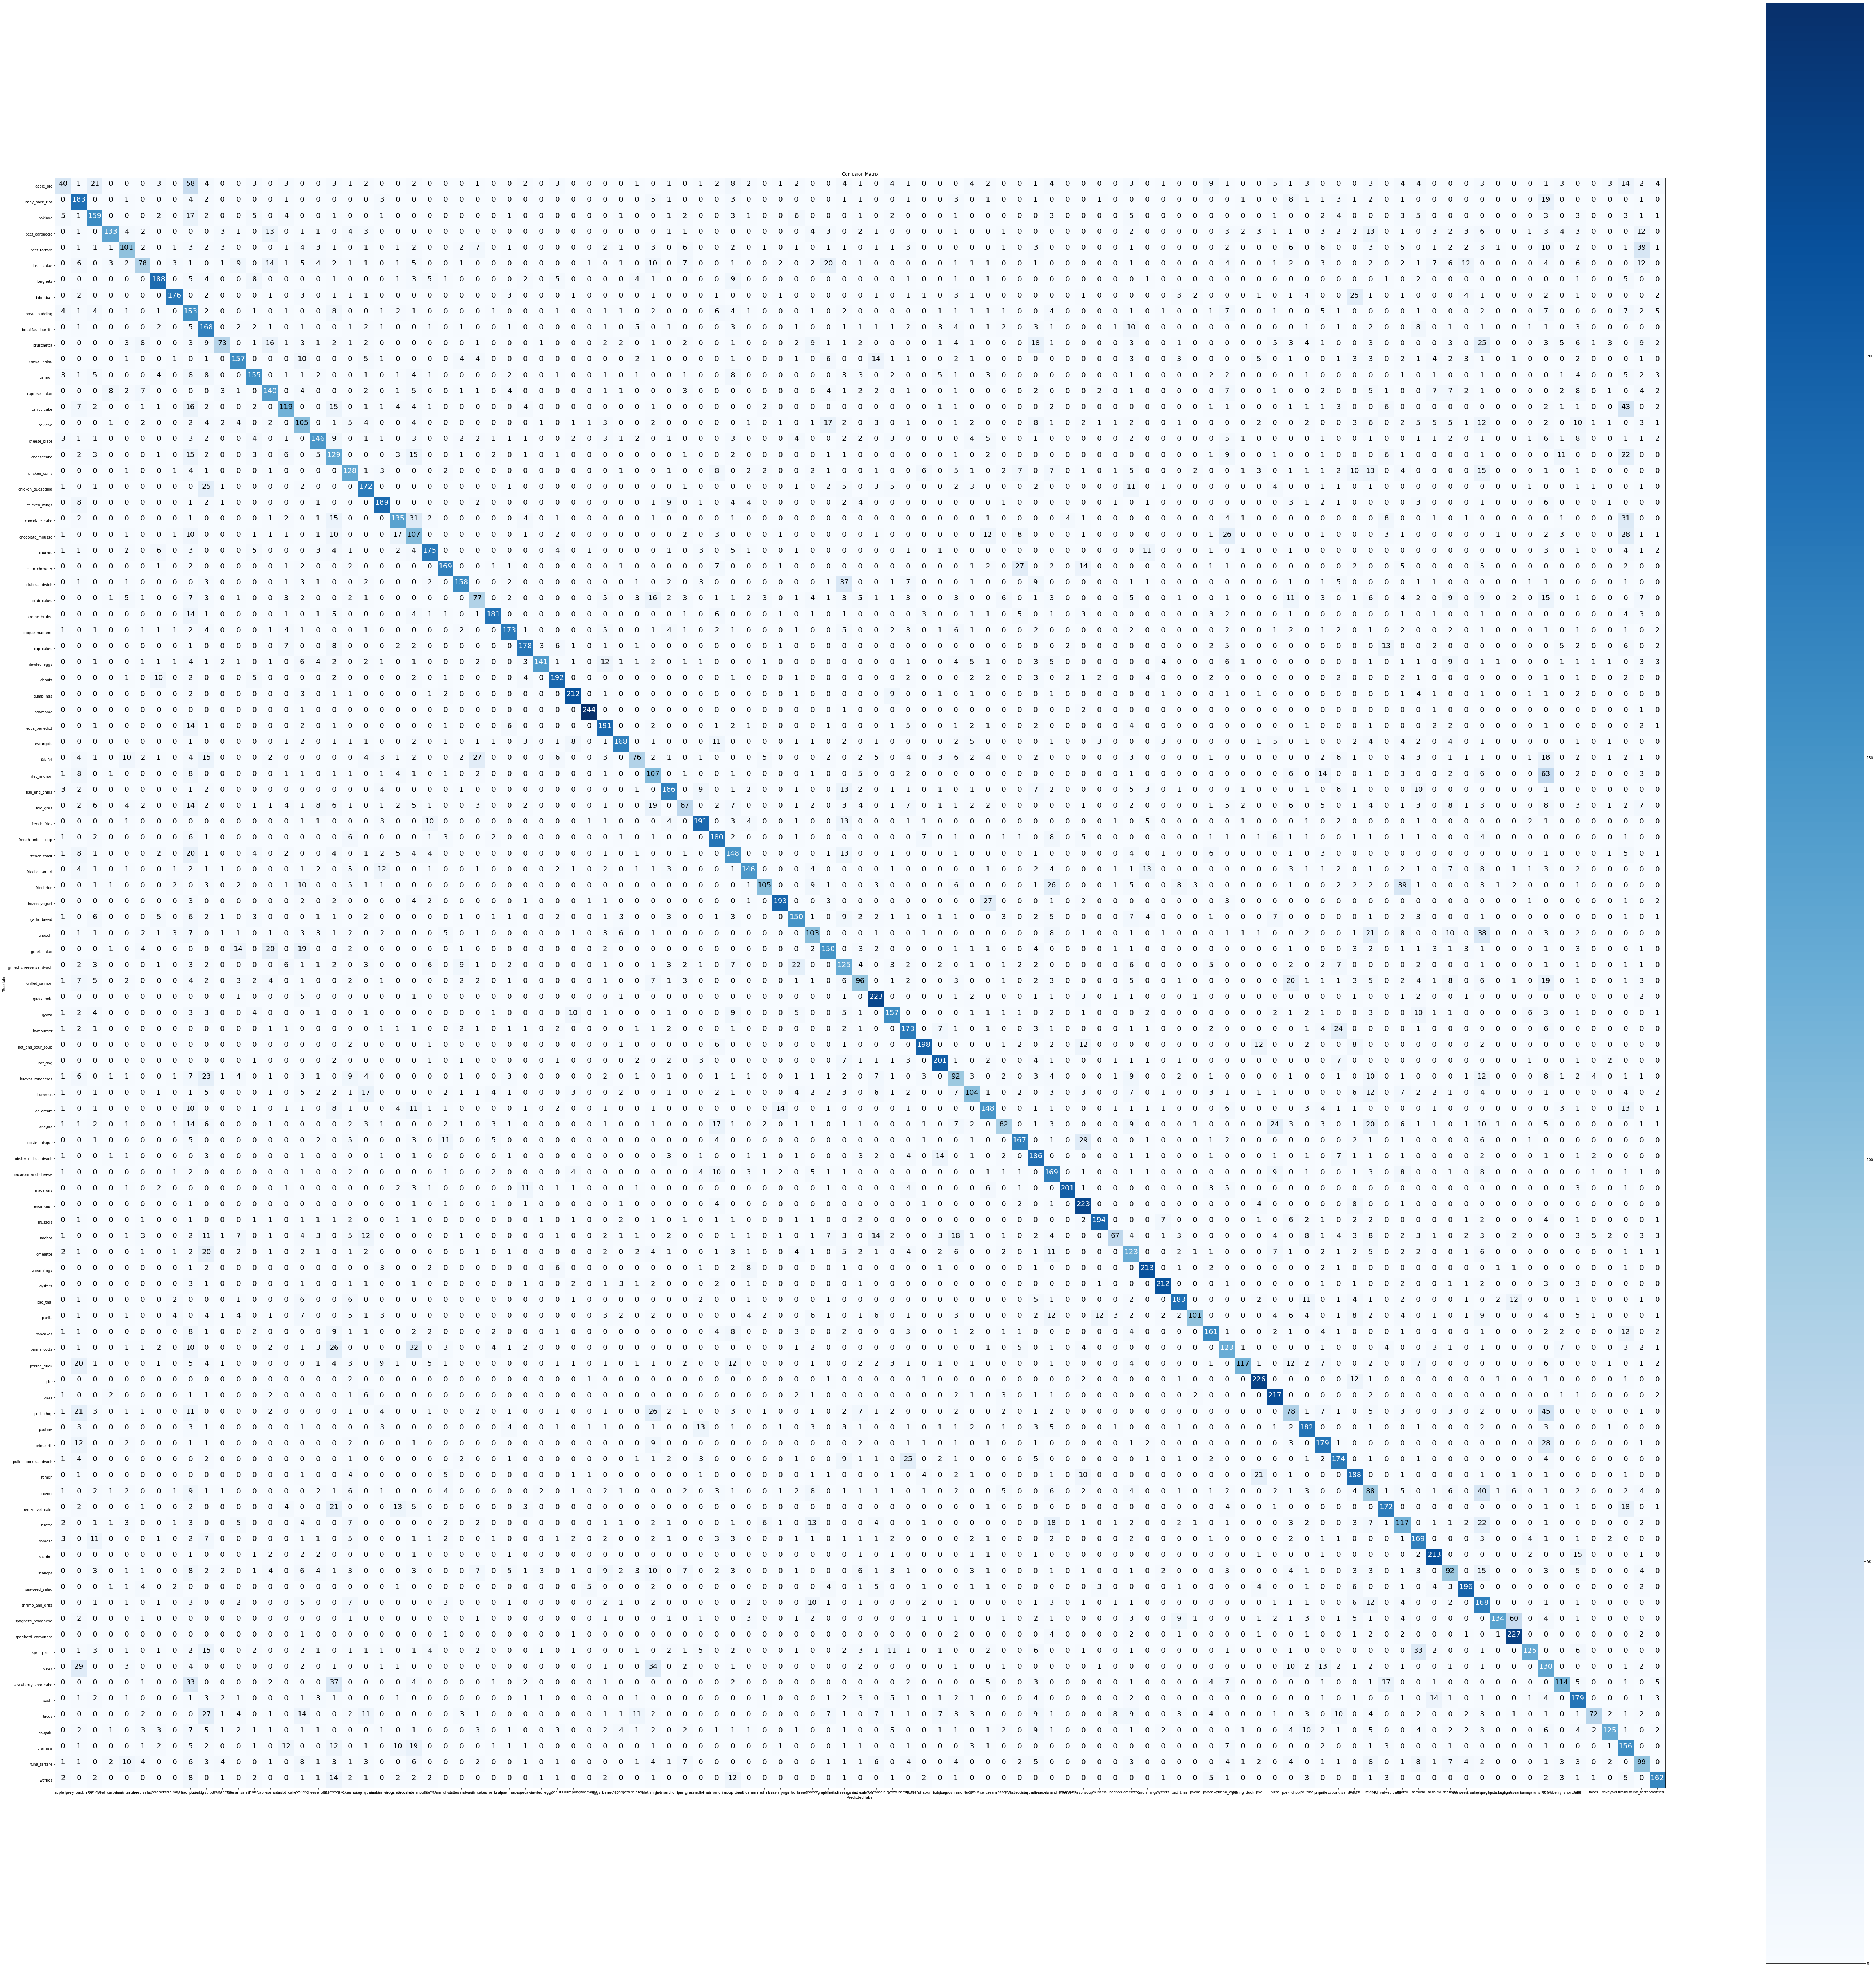

In [31]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.44      0.16      0.23       250
           1       0.49      0.73      0.59       250
           2       0.60      0.64      0.62       250
           3       0.83      0.53      0.65       250
           4       0.57      0.40      0.47       250
           5       0.57      0.31      0.40       250
           6       0.77      0.75      0.76       250
           7       0.86      0.70      0.77       250
           8       0.25      0.61      0.35       250
           9       0.38      0.67      0.49       250
          10       0.68      0.29      0.41       250
          11       0.69      0.63      0.66       250
          12       0.70      0.62      0.66       250
          13       0.57      0.56      0.57       250
          14       0.62      0.48      0.54       250
          15       0.36      0.42      0.39       250
          16       0.66      0.58      0.62       250
          17       0.34    

In [33]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.43956043956043955,
  'recall': 0.16,
  'f1-score': 0.2346041055718475,
  'support': 250},
 '1': {'precision': 0.488,
  'recall': 0.732,
  'f1-score': 0.5856,
  'support': 250},
 '2': {'precision': 0.5977443609022557,
  'recall': 0.636,
  'f1-score': 0.6162790697674418,
  'support': 250},
 '3': {'precision': 0.83125,
  'recall': 0.532,
  'f1-score': 0.6487804878048781,
  'support': 250},
 '4': {'precision': 0.5706214689265536,
  'recall': 0.404,
  'f1-score': 0.4730679156908665,
  'support': 250},
 '5': {'precision': 0.5652173913043478,
  'recall': 0.312,
  'f1-score': 0.4020618556701031,
  'support': 250},
 '6': {'precision': 0.7673469387755102,
  'recall': 0.752,
  'f1-score': 0.7595959595959596,
  'support': 250},
 '7': {'precision': 0.8585365853658536,
  'recall': 0.704,
  'f1-score': 0.7736263736263737,
  'support': 250},
 '8': {'precision': 0.24519230769230768,
  'recall': 0.612,
  'f1-score': 0.3501144164759725,
  'support': 250},
 '9': {'precision': 0.38268

In [34]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy": 
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2346041055718475,
 'baby_back_ribs': 0.5856,
 'baklava': 0.6162790697674418,
 'beef_carpaccio': 0.6487804878048781,
 'beef_tartare': 0.4730679156908665,
 'beet_salad': 0.4020618556701031,
 'beignets': 0.7595959595959596,
 'bibimbap': 0.7736263736263737,
 'bread_pudding': 0.3501144164759725,
 'breakfast_burrito': 0.4876632801161103,
 'bruschetta': 0.40782122905027934,
 'caesar_salad': 0.6555323590814196,
 'cannoli': 0.6567796610169492,
 'caprese_salad': 0.5656565656565656,
 'carrot_cake': 0.5372460496613995,
 'ceviche': 0.38961038961038963,
 'cheese_plate': 0.6199575371549894,
 'cheesecake': 0.40822784810126583,
 'chicken_curry': 0.4970873786407767,
 'chicken_quesadilla': 0.6466165413533834,
 'chicken_wings': 0.7397260273972602,
 'chocolate_cake': 0.5756929637526652,
 'chocolate_mousse': 0.3767605633802817,
 'churros': 0.7216494845360825,
 'clam_chowder': 0.7100840336134454,
 'club_sandwich': 0.7022222222222222,
 'crab_cakes': 0.3765281173594132,
 'creme_brulee': 0.77849

In [35]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33        edamame  0.962525
63       macarons  0.875817
69        oysters  0.861789
32      dumplings  0.834646
75            pho  0.829358
..            ...       ...
8   bread_pudding  0.350114
93          steak  0.348525
77      pork_chop  0.324324
82        ravioli  0.306620
0       apple_pie  0.234604

[101 rows x 2 columns]

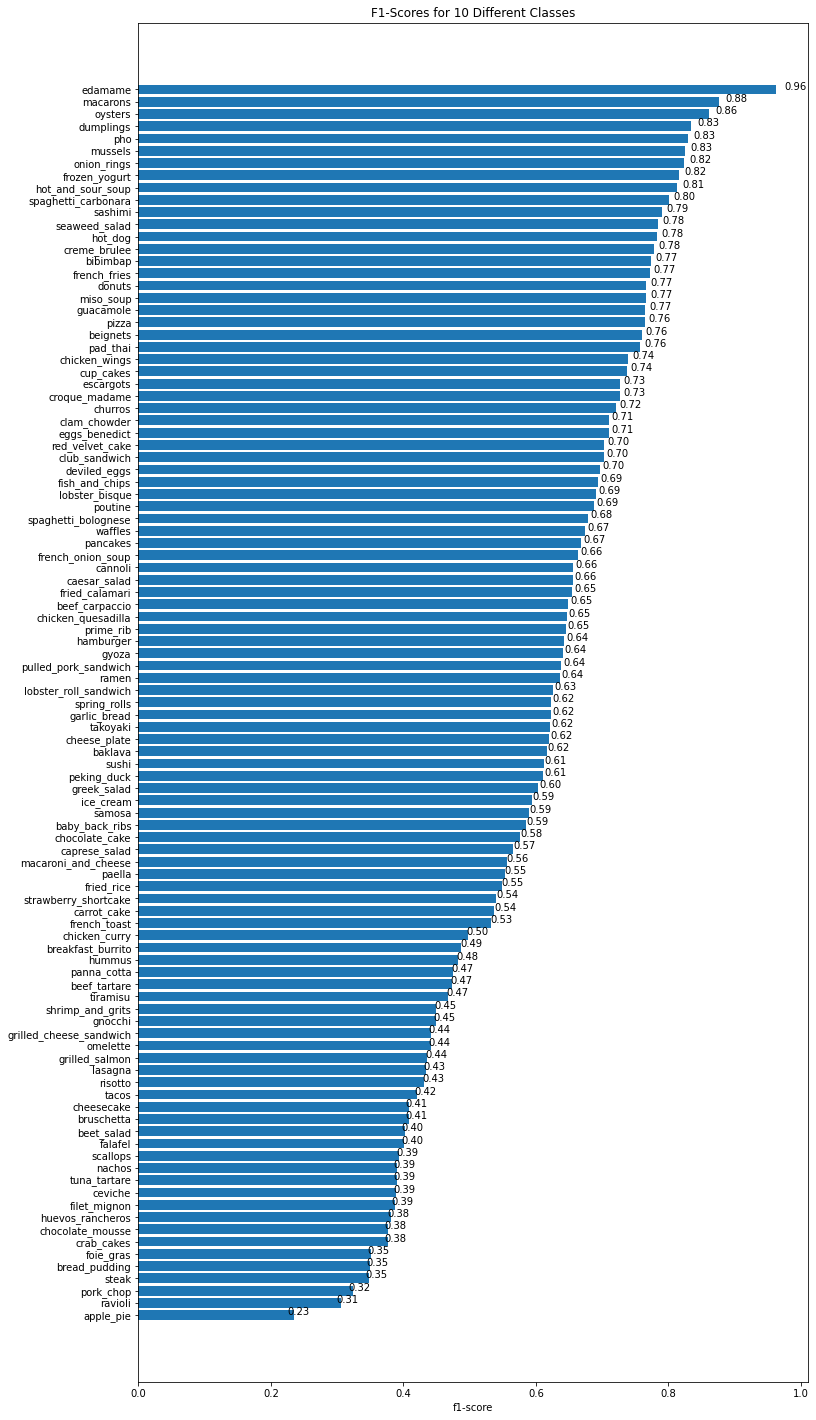

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); 

def autolabel(rects): 
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Making predictions on random images

1/1 [==============================] - 0s 44ms/step


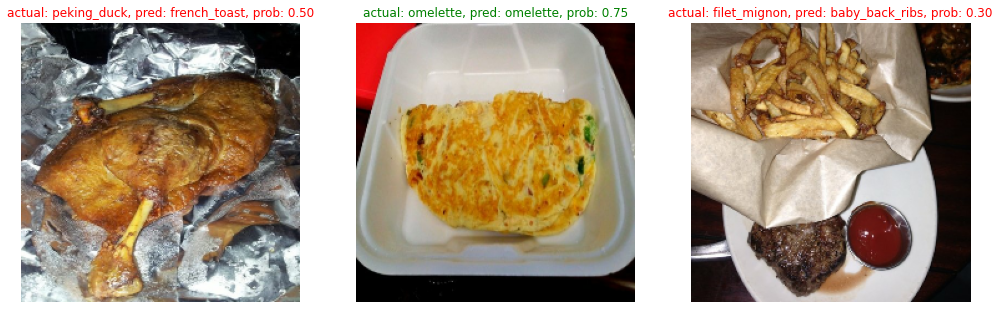

In [39]:
import os
import random
from helper_functions import load_and_prep_image
plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

1/1 [==============================] - 0s 29ms/step


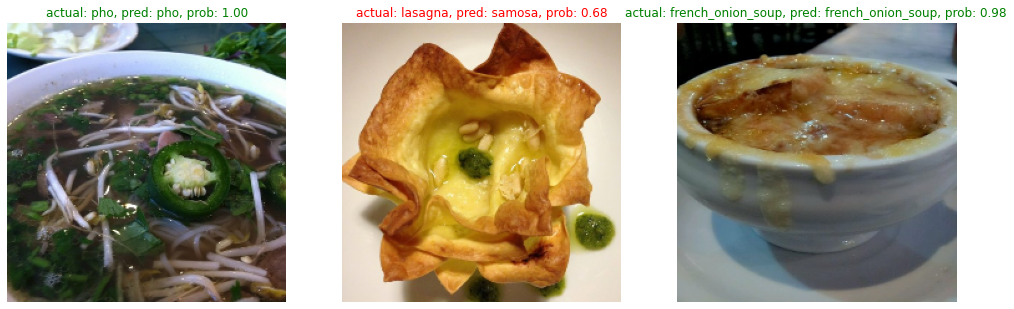

In [40]:
plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Most wrong predictions

In [41]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [42]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.197687        apple_pie        apple_pie  
1   0.896221        apple_pie        apple_pie  
2   0.287967        apple_pie        apple_pie  
3   0.182046        apple_pie    bread_pudding  
4   0.696314        apple_pie    bread_pudding

In [43]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.197687        apple_pie        apple_pie          True  
1   0.896221        apple_pie        apple_pie          True  
2   0.287967        apple_pie        apple_pie          True  
3   0.182046        apple_pie    bread_pudding         False  
4   0.696314        apple_pie    bread_pudding         False

In [44]:
# top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
8794   b'101_food_classes_10_percent/test/escargots/1...      35      41   
5849   b'101_food_classes_10_percent/test/churros/254...      23      68   
21652  b'101_food_classes_10_percent/test/sashimi/306...      86      95   
5652   b'101_food_classes_10_percent/test/chocolate_m...      22      98   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
722    b'101_food_classes_10_percent/test/baklava/640...       2      85   
4836   b'101_food_classes_10_percent/test/chicken_que...      19       9   
20488  b'101_food_classes_10_percent/test/ramen/76661...      81      75   
10013  b'101_food_classes_10_percent/test/french_frie...      40      43   
24479  b'101_food_classes_10_percent/test/takoyaki/68...      97      78   
5829   b'101_food_classes_10_percent/test/churros/227...      23      68   
9326   b'101_food_classes_10_percent/test/filet_migno...      37      79   
4583   b'101_food_classes_10_percent/test/chicken_cur...      18      60   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   

       pred_conf    y_true_classname   y_pred_classname  pred_correct  
18001   0.999261            pancakes           omelette         False  
10880   0.997326      fried_calamari        onion_rings         False  
23797   0.996555               sushi            sashimi         False  
15142   0.996344      lobster_bisque          miso_soup         False  
191     0.995835           apple_pie             donuts         False  
10854   0.995026      fried_calamari        onion_rings         False  
8794    0.994859           escargots  french_onion_soup         False  
5849    0.994294             churros        onion_rings         False  
21652   0.994199             sashimi              sushi         False  
5652    0.993855    chocolate_mousse           tiramisu         False  
10847   0.993494      fried_calamari        onion_rings         False  
722     0.993160             baklava             samosa         False  
4836    0.992313  chicken_quesadilla  breakfast_burrito         False  
20488   0.992224               ramen                pho         False  
10013   0.991989        french_fries     fried_calamari         False  
24479   0.990925            takoyaki            poutine         False  
5829    0.990905             churros        onion_rings         False  
9326    0.990879        filet_mignon          prime_rib         False  
4583    0.990809       chicken_curry     lobster_bisque         False  
5114    0.990748       chicken_wings     fish_and_chips         False

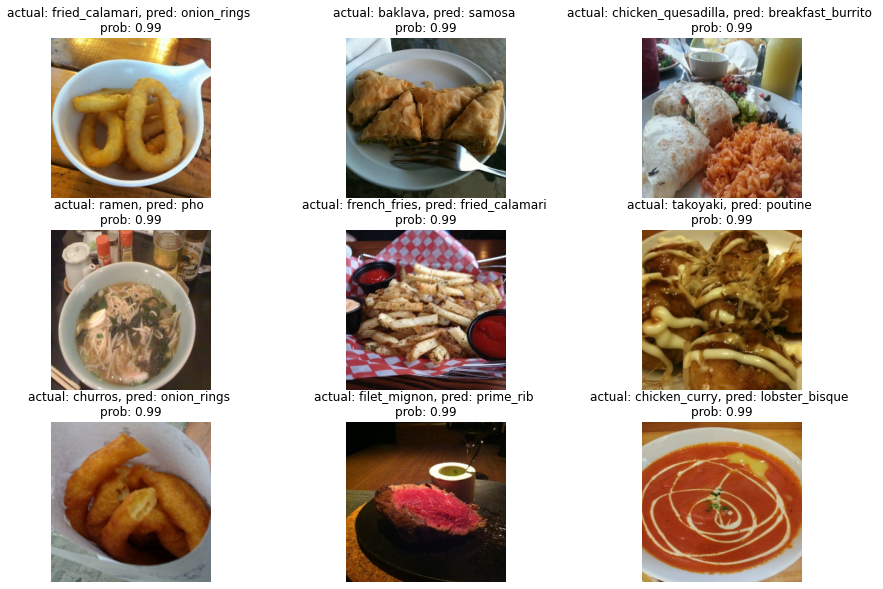

In [45]:
images_to_view = 9
start_index = 10 
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row 
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

### Testing model on custom images

In [46]:
!unzip /content/gdrive/MyDrive/food_dataset/custom_food_images.zip

--2023-03-14 11:33:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.88MB/s    in 1.6s    

2023-03-14 11:33:52 (7.88 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [47]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 49ms/step


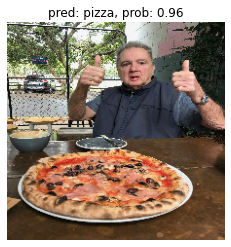

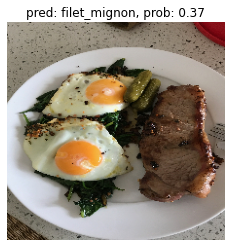

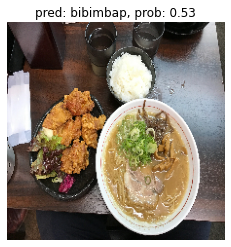

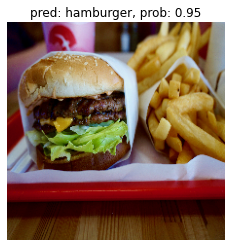

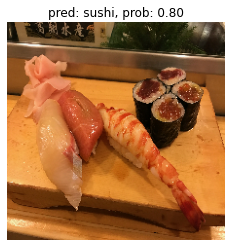

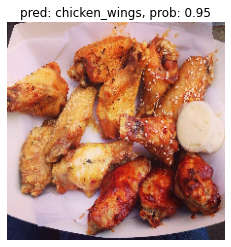

In [48]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 
  plt.figure()
  plt.imshow(img/255.) 
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

# Training and Testing Model with full 100% data

### Getting Dataset from tensorflow datasets

In [49]:
import tensorflow_datasets as tfds

In [50]:
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, 
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteXJ4NMG/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteXJ4NMG/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [51]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

### checking shape of images

In [52]:
#getting class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [53]:
train_one_sample = train_data.take(1)
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 43
  Class name (str form): fried_calamari
        


In [54]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[71, 60, 56],
        [70, 59, 55],
        [70, 59, 55],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[62, 51, 47],
        [64, 53, 49],
        [66, 55, 51],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[61, 50, 46],
        [65, 54, 50],
        [68, 57, 53],
        ...,
        [66, 61, 68],
        [65, 60, 67],
        [63, 58, 65]],

       ...,

       [[63, 64, 66],
        [64, 65, 67],
        [67, 67, 69],
        ...,
        [45, 42, 49],
        [45, 42, 49],
        [45, 42, 49]],

       [[64, 64, 66],
        [64, 64, 66],
        [65, 65, 67],
        ...,
        [44, 41, 48],
        [44, 41, 48],
        [44, 41, 48]],

       [[62, 62, 64],
        [62, 62, 64],
        [62, 62, 64],
        ...,
        [43, 40, 47],
        [42, 39, 46],
        [42, 39, 46]]], dtype=uint8)>

### Plotting the image

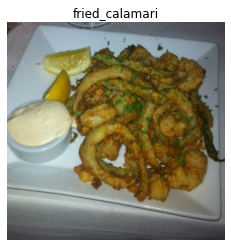

In [55]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

### Preprocessing functions

In [56]:
def preprocess_img(image, label, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape]) 
    return tf.cast(image, tf.float32), label 

In [57]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[71 60 56]
  [70 59 55]
  [70 59 55]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]

 [[62 51 47]
  [64 53 49]
  [66 55 51]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 65.81122   54.811222  50.811222]
  [ 73.331635  62.331635  58.331635]
  [104.015305  89.80102   86.80102 ]
  ...
  [ 61.85712   59.071384  65.64286 ]
  [ 65.        60.        67.      ]
  [ 64.64282   59.642822  66.64282 ]]

 [[ 67.28571   56.285717  52.285717]
  [ 66.47449   55.47449   51.47449 ]
  [ 67.73979   53.525505  50.525505]
  ...
  [ 64.14284   61.3571    67.92857 ]
  [ 65.93368   60.933674  67.93368 ]
  [ 64.285645  59.285645  66.285645]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


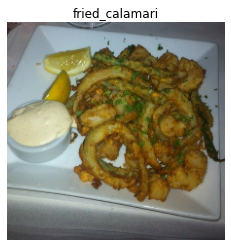

In [58]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

### Preparing Dataset

In [59]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [60]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [61]:
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True, 
                                                      save_weights_only=True,
                                                      verbose=0)  

In [62]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [63]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Creating a base model

In [64]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [65]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [66]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [67]:
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

In [68]:
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230314-114858
Epoch 1/3
2368/2368 [==============================] - 208s 83ms/step - loss: 1.7158 - accuracy: 0.5822 - val_loss: 1.1261 - val_accuracy: 0.6984
Epoch 2/3
2368/2368 [==============================] - 192s 80ms/step - loss: 1.1986 - accuracy: 0.6892 - val_loss: 1.0267 - val_accuracy: 0.7158
Epoch 3/3
2368/2368 [==============================] - 190s 79ms/step - loss: 1.0527 - accuracy: 0.7253 - val_loss: 0.9899 - val_accuracy: 0.7256


In [69]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 51s 65ms/step - loss: 1.0001 - accuracy: 0.7279


[1.0001144409179688, 0.7279207706451416]

In [70]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [71]:
checkpoint_path

'model_checkpoints/cp.ckpt'

In [72]:
cloned_model.load_weights(checkpoint_path)

In [73]:
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [74]:
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 53s 64ms/step - loss: 1.3648 - accuracy: 0.6331


In [75]:
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float3

### Fine Tuning

In [76]:
fine_tuned_model = cloned_model

In [77]:
#cheking for frozen layers
for layer in fine_tuned_model.layers:
    layer.trainable = True 
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [78]:
for layer in fine_tuned_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "mixed_float16">
normalization_1 True float32 <Policy "mixed_float16">
rescaling_3 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_f

In [79]:
# Setup EarlyStopping callback 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3) 

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [80]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [81]:
#compiling the model
fine_tuned_model.compile(loss="sparse_categorical_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(0.0001), 
                        metrics=["accuracy"])

In [83]:
history_101_food_classes_all_data_fine_tune = fine_tuned_model.fit(train_data,
                                                        epochs=100, 
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), 
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), 
                                                                   model_checkpoint, 
                                                                   early_stopping, 
                                                                   reduce_lr]) 

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230314-121513
Epoch 1/100
2368/2368 [==============================] - 380s 159ms/step - loss: 0.5682 - accuracy: 0.8419 - val_loss: 0.8107 - val_accuracy: 0.7799 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 360s 151ms/step - loss: 0.3246 - accuracy: 0.9077 - val_loss: 0.8634 - val_accuracy: 0.7765 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9490
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 360s 151ms/step - loss: 0.1731 - accuracy: 0.9490 - val_loss: 0.9757 - val_accuracy: 0.7770 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 357s 150ms/step - loss: 0.0354 - accuracy: 0.9919 - val_loss: 1.0534 - val_accuracy: 0.7979 - lr: 2.0000e-05


In [84]:
fine_tuned_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-tra

In [85]:
results_fine_tuned_model = fine_tuned_model.evaluate(test_data)
results_fine_tuned_model

790/790 [==============================] - 52s 66ms/step - loss: 1.0401 - accuracy: 0.7983


[1.040095567703247, 0.7982574105262756]

* We successully created a model that beats ImageNet Food101 Paper with an accuracy of 79.82%

### Making predictions on random images

1/1 [==============================] - 0s 28ms/step


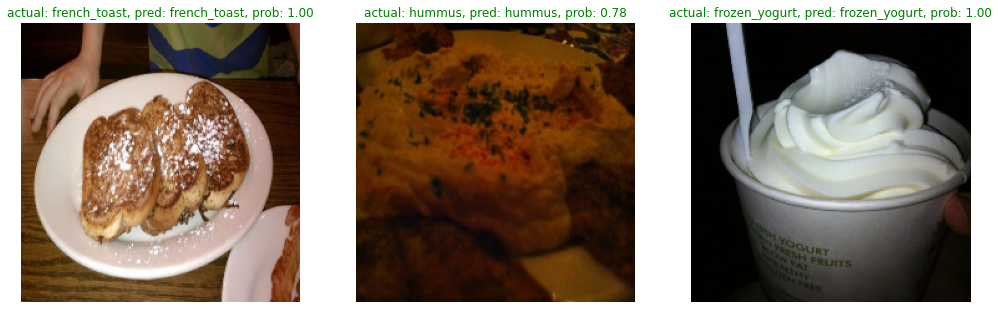

In [91]:
plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) 
  pred_prob = fine_tuned_model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);